In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import warnings
import geopandas as gpd
warnings.filterwarnings('ignore')

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Survey patients characteristics

In [3]:
file_path = '../data/gitignoreDATA/nys-patient-characteristics-survey-pcs-2015/patient-characteristics-survey-pcs-2015.csv'

check_df = pd.read_csv(file_path)
print(f'shape: {check_df.shape}')
n_cols_unknown = len([col for col in check_df.columns if "UNKNOWN" in check_df[col].values])

print(f'{n_cols_unknown} out of {len(check_df.columns)} columns contain the UNKNOWN value:\n')

for col in check_df.columns:
    col_vals = check_df[col].values
    if 'UNKNOWN' in col_vals:
        perc_unknown = len(col_vals[col_vals=='UNKNOWN'])/len(col_vals)
        if perc_unknown>0.1:
            check_df.drop(col,1,inplace=True)
        else:
            indexes_unknown = check_df[check_df[col]=="UNKNOWN"].index.values
            check_df.drop(indexes_unknown,inplace=True)

shape: (179096, 67)
58 out of 67 columns contain the UNKNOWN value:



Three digit zip code 888
indicates the client was homeless at the time of the survey
and three digit zip code 999 indicates the residential zip code
is unknown.

In [4]:
zip_code_numerosity = check_df.groupby('Three Digit Residence Zip Code').size().reset_index().sort_values(by=0,ascending=False).reset_index(drop=True).rename(columns={0:'numerosity'})

In [5]:
to_plot = zip_code_numerosity[zip_code_numerosity['Three Digit Residence Zip Code'].isin([888,999])==False].rename(columns={'Three Digit Residence Zip Code':'ZIP3'})

In [6]:
fp = '../data/gitignoreDATA/zip3/zip3.shp'
map_df = gpd.read_file(fp)

In [7]:
to_plot['ZIP3'] = to_plot['ZIP3'].astype(int)
map_df['ZIP3'] = map_df['ZIP3'].astype(int)

merged_map_df = map_df.merge(to_plot,on='ZIP3',how='inner')
merged_map_df['ZIP3'] = merged_map_df['ZIP3'].astype(object)

In [8]:
merged_map_df['log_numerosity'] = pd.Series(np.log(np.log(to_plot.numerosity.values)),index=merged_map_df.index)

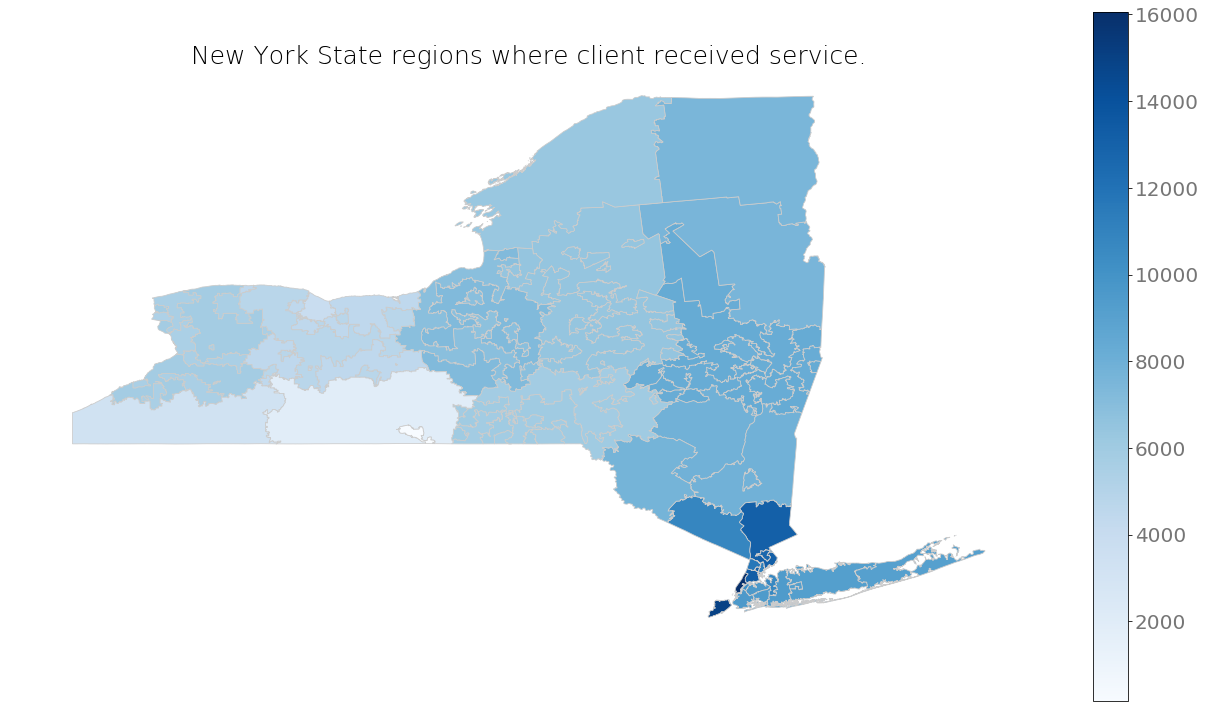

In [9]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'log_numerosity'
# set the range for the choropleth
vmin,vmax = 156, 16065
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 10))

merged_map_df.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('New York State regions where client received service.', fontdict={'fontsize': '25', 'fontweight' : '3'})

sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20,labelcolor='#767676')
plt.tight_layout()
savefig('../data/gitignoreDATA/presentazione_lipari_MARLENA/map.png',transparent=True)
show()

In [10]:
homeless = zip_code_numerosity[zip_code_numerosity['Three Digit Residence Zip Code']==888].numerosity.values[0]
unknown = zip_code_numerosity[zip_code_numerosity['Three Digit Residence Zip Code']==999].numerosity.values[0]
declared = zip_code_numerosity[zip_code_numerosity['Three Digit Residence Zip Code'].isin([888,999])==False].sum().numerosity

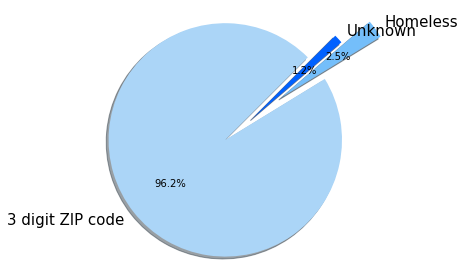

In [11]:
# Pie chart
labels = ['3 digit ZIP code', 'Homeless', 'Unknown']
sizes = [declared, homeless, unknown]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0.3, 0.3, 0)  
fig1, ax1 = plt.subplots()
#autopct='%1.1f%%'
patches, texts, autotexts = ax1.pie(sizes, explode=explode,shadow=True, startangle=45,autopct='%1.1f%%',colors=['#abd5f7','#74befa','#0061ff'],labels=labels)
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)
texts[2].set_fontsize(15)

ax1.axis('equal') 
plt.tight_layout()
savefig('../data/gitignoreDATA/presentazione_lipari_MARLENA/pie.png',transparent=True)
plt.show()